**In case of problems or questions, please first check the list of [Frequently Asked Questions (FAQ)](https://stardist.net/docs/faq.html).**

Please shutdown all other training/prediction notebooks before running this notebook (as those might occupy the GPU memory otherwise).

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()

/tmp/ipykernel_69895/2709048481.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None
2022-01-21 12:21:26.176942: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Data

We assume that data has already been downloaded in via notebook [1_data.ipynb](1_data.ipynb).  
We now load images from the sub-folder `test` that have not been used during training.

In [3]:
data_dir = '/mnt/home/ies/andreas.ettinger/data/dl-course-2022/testdata/ims/'

In [2]:
import h5py

In [4]:
from skimage.transform import resize

In [5]:
import os

In [17]:
ims_files = os.listdir(data_dir)[0]

In [18]:
from random import randint

In [19]:
rand_tp = [randint(0,20) for i in range(0,3)]

In [68]:
test_images = []

In [71]:
hf = h5py.File(os.path.join(data_dir, ims_files),'r')
for i in rand_tp:
    nz, ny, nx = hf['/DataSet/ResolutionLevel 0/TimePoint '+str(i)+'/Channel 0/Data'].shape
    new_img = np.zeros((nz, ny, nx))
    for z in range(0, nz):
         new_img[z,:,:] = hf['/DataSet/ResolutionLevel 0/TimePoint '+str(i)+'/Channel 0/Data'][z, :, :]
    test_images.append(new_img)
hf.close()

In [72]:
from functools import partial

In [74]:
X = list(map(partial(resize, output_shape=(nz, 512,512), preserve_range=True), test_images))

X = sorted(glob('d'))
X = list(map(imread,X))

n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [75]:
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

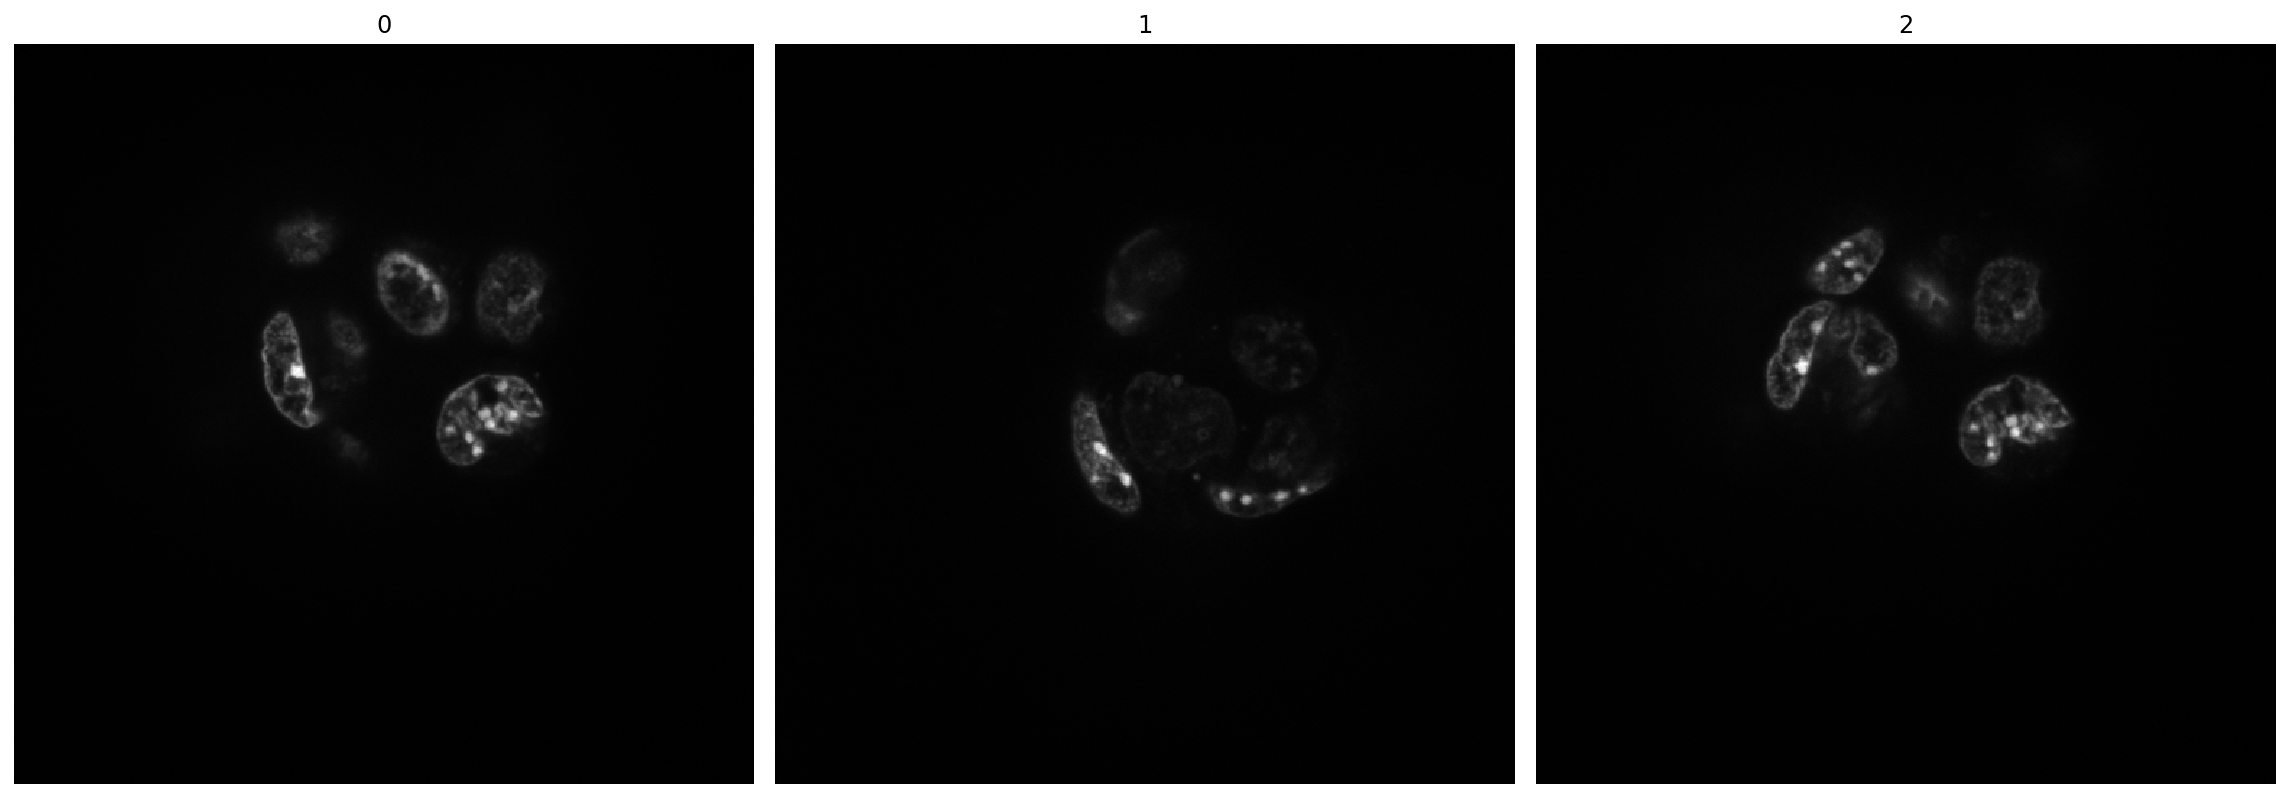

In [76]:
# show all test images
if True:
    fig, ax = plt.subplots(1,3, figsize=(16,16))
    for i,(a,x) in enumerate(zip(ax.flat, X)):
        a.imshow(x[x.shape[0]//2],cmap='gray')
        a.set_title(i)
    [a.axis('off') for a in ax.flat]
    plt.tight_layout()
None;

# Load trained model

If you trained your own StarDist model (and optimized its thresholds) via notebook [2_training.ipynb](2_training.ipynb), then please set `demo_model = False` below.

demo_model = True

if demo_model:
    print (
        "NOTE: This is loading a previously trained demo model!\n"
        "      Please set the variable 'demo_model = False' to load your own trained model.",
        file=sys.stderr, flush=True
    )
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model = StarDist3D(None, name='stardist', basedir='models')
None;

In [77]:
 model = StarDist3D(None, name='stardist', basedir='/mnt/home/ies/andreas.ettinger/repos/embl-dl-2022/stardist3D_andreas_400epochs/')

2022-01-21 12:46:50.113973: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-21 12:46:50.147348: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-21 12:46:51.324708: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2022-01-21 12:46:51.324811: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-01-21 12:46:51.581296: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-01-21 12:46:51.581427: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.550262, nms_thresh=0.3.


## Prediction

Make sure to normalize the input image beforehand or supply a `normalizer` to the prediction function.

Calling `model.predict_instances` will
- predict object probabilities and star-convex polygon distances (see `model.predict` if you want those)
- perform non-maximum suppression (with overlap threshold `nms_thresh`) for polygons above object probability threshold `prob_thresh`.
- render all remaining polygon instances in a label image
- return the label instances image and also the details (coordinates, etc.) of all remaining polygons

In [78]:
img = normalize(X[2], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)

2022-01-21 12:47:53.365392: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-21 12:47:53.366822: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz
2022-01-21 12:47:53.906492: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2022-01-21 12:48:00.327970: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


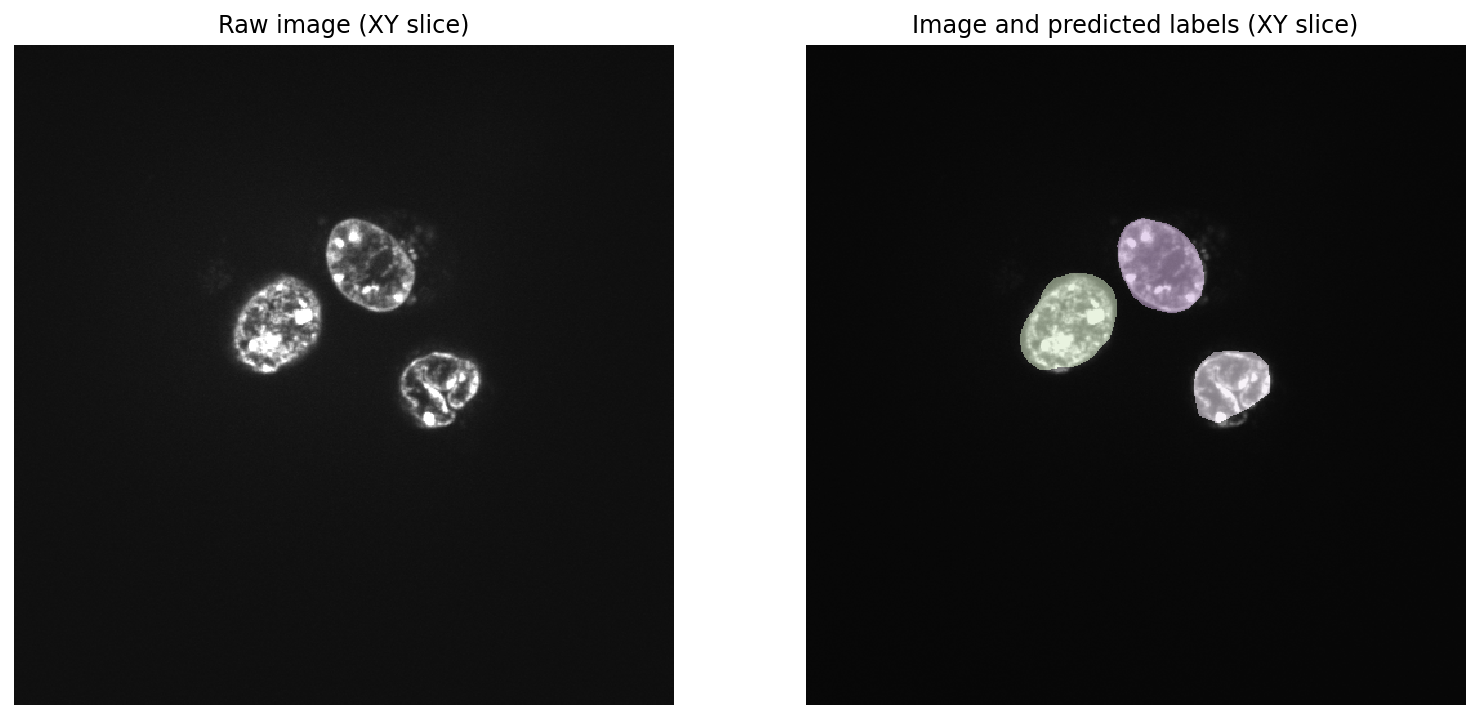

In [79]:
plt.figure(figsize=(13,10))
z = max(0, img.shape[0] // 2 - 5)
plt.subplot(121)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.title('Raw image (XY slice)')
plt.axis('off')
plt.subplot(122)
plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
plt.title('Image and predicted labels (XY slice)')
plt.axis('off');

In [81]:
output_ex_dir = '/mnt/home/ies/andreas.ettinger/repos/embl-dl-2022/stardist_prediction_examples'

In [90]:
examples_ids = ['-'.join([ims_files.replace('.ims',''), str(tp)]) for tp in rand_tp]

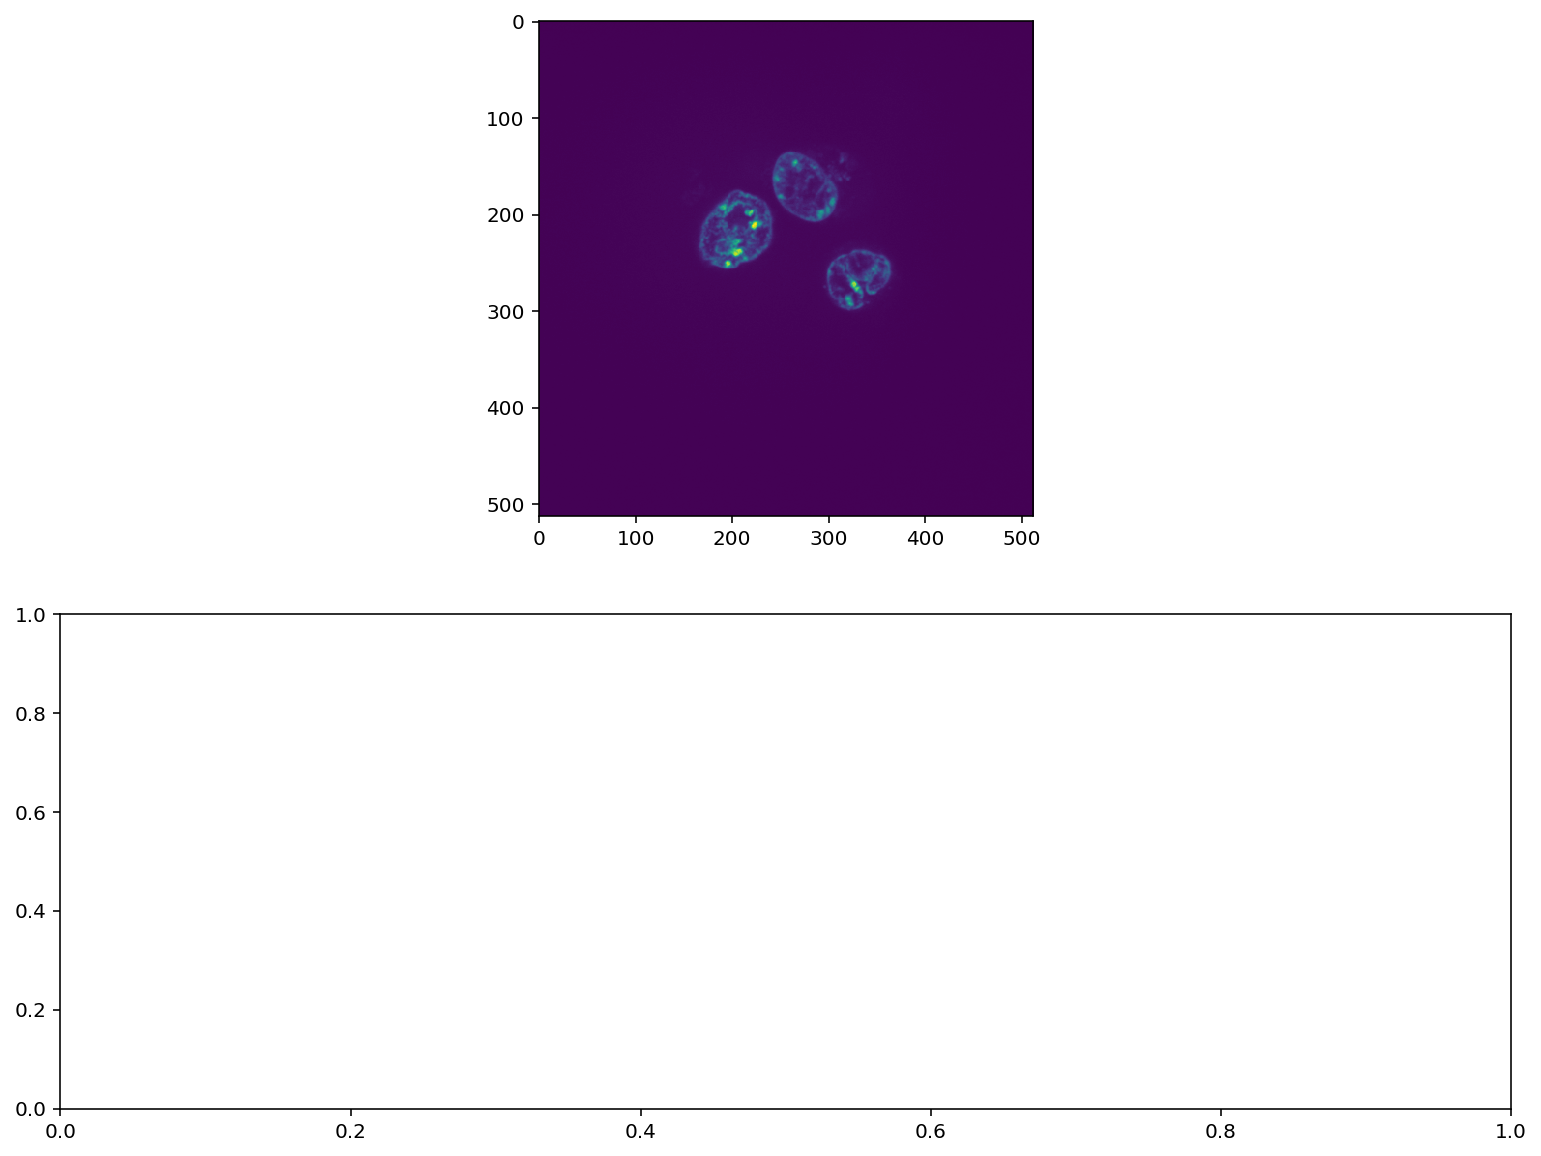

In [95]:
fig, ax = plt.subplots(2, 1, figsize=(13,10))
ax[0].imshow(img[12,:,:])

In [96]:
img.shape

(32, 512, 512)

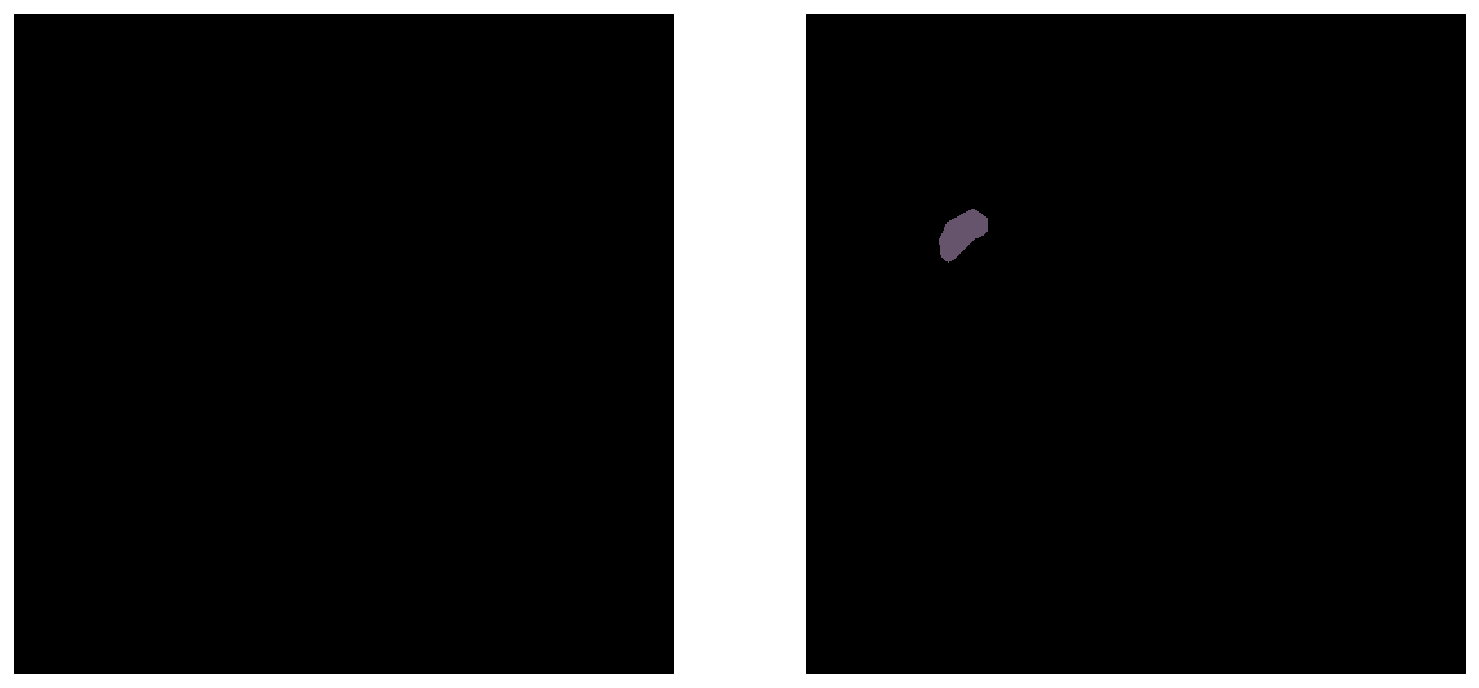

In [111]:
fig, ax = plt.subplots(1,2, figsize=(13,10))
for img, fname in zip(X, examples_ids):
    if not os.path.exists(os.path.join(output_ex_dir, fname)):
        os.mkdir(os.path.join(output_ex_dir, fname))
    img_n = normalize(img, 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img_n)
    nz = img.shape[0]
    for z in range(0,nz):
        ax[0].imshow(img_n[z,:,:], clim=(0,1), cmap='gray')
        ax[0].axis('off')
        ax[1].imshow(img_n[z,:,:], clim=(0,1), cmap='gray')
        ax[1].imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
        ax[1].axis('off')
        plt.savefig(os.path.join(output_ex_dir, fname, fname+'-'+str(z)+'.png'));

(-0.5, 511.5, 511.5, -0.5)

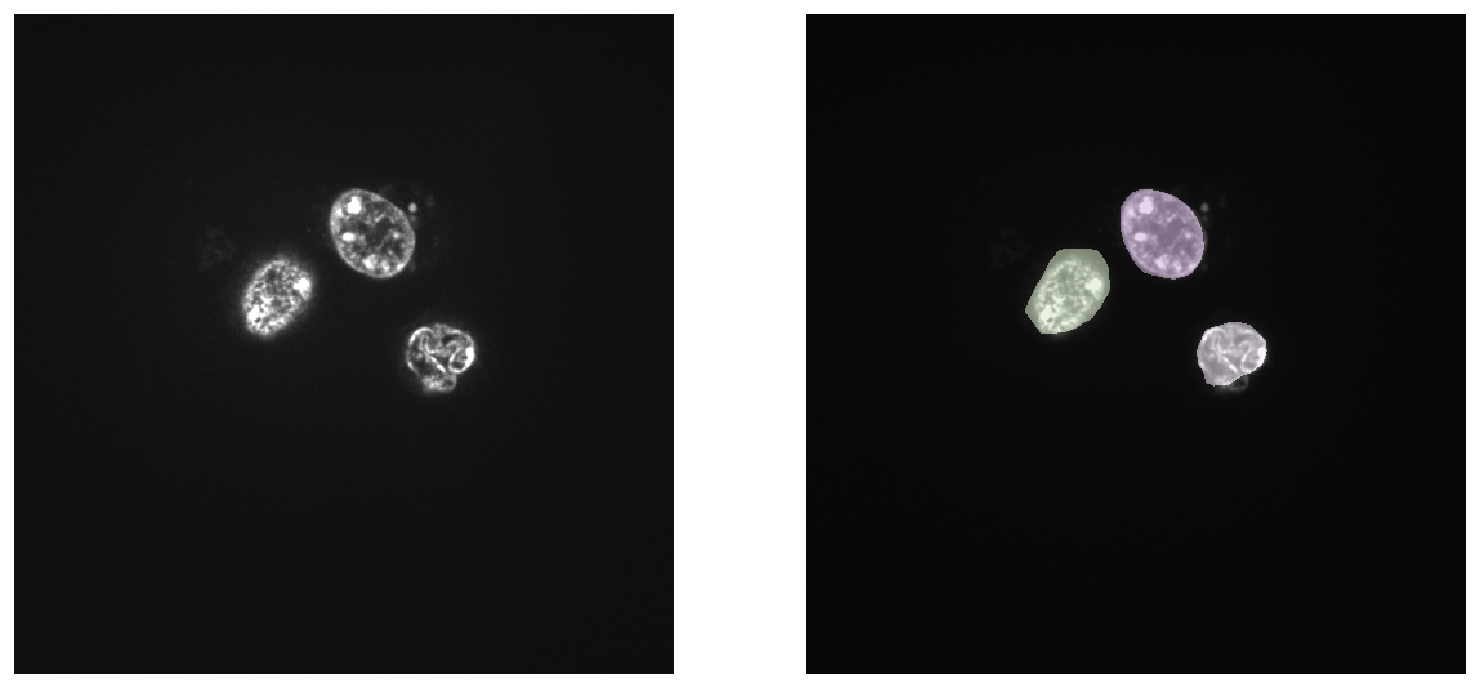

In [109]:
fig, ax = plt.subplots(1,2, figsize=(13,10))

ax[0].imshow(img_n[10,:,:], clim=(0,1), cmap='gray')
ax[0].axis('off')
ax[1].imshow(img_n[10,:,:], clim=(0,1), cmap='gray')
ax[1].imshow(labels[10], cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')

In [117]:
np.max(img_n)

3.5430145

In [137]:
fname

'2020-06-25_18.38.43_20200625-mESC-Ndc80-clone7_F07-12'

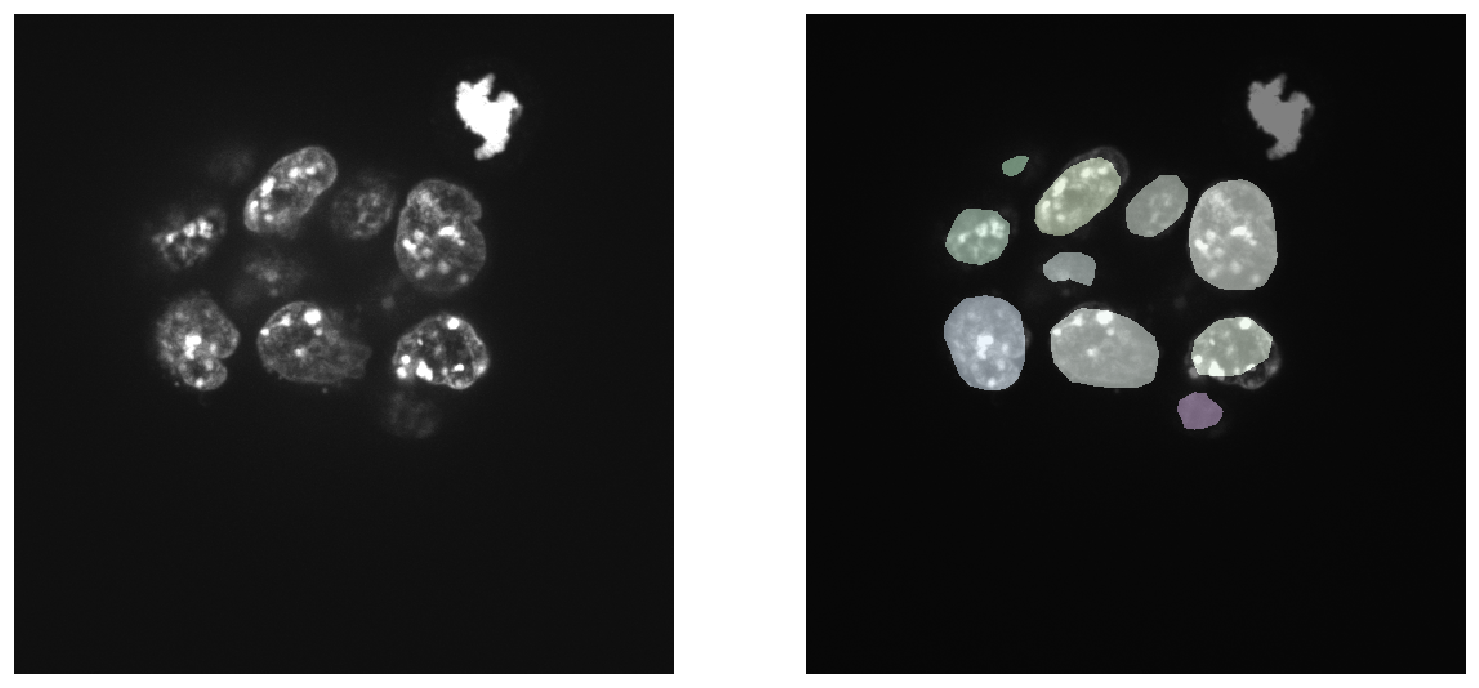

In [156]:
fig, ax = plt.subplots(1,2,figsize=(13,10))
ax[0].imshow(np.amax(img_n[20:23,:,:],axis=0), clim=(0,1), cmap='gray')
ax[0].axis('off')
ax[1].imshow(np.amax(img_n[20:23,:,:],axis=0), clim=(0,1), cmap='gray')
ax[1].imshow(np.amax(labels[20:23,:,:],axis=0), cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')
plt.savefig(os.path.join(output_ex_dir, fname+'-projection-XY.png'))

In [151]:
img_n.shape

(32, 512, 512)

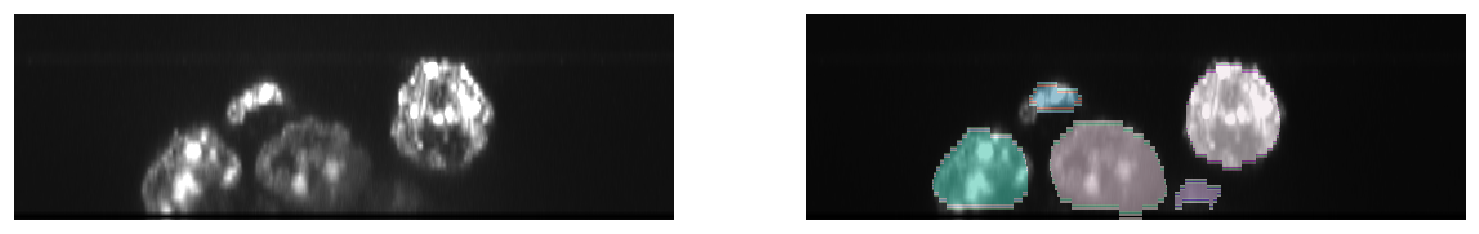

In [157]:
fig, ax = plt.subplots(1,2,figsize=(13,10))
ax[0].imshow(resize(np.amax(img_n[:,250:260,:],axis=1), output_shape=(160,512)), clim=(0,1), cmap='gray')
ax[0].axis('off')
ax[1].imshow(resize(np.amax(img_n[:,250:260,:],axis=1), output_shape=(160,512)), clim=(0,1), cmap='gray')
ax[1].imshow(resize(np.amax(labels[:,250:260,:],axis=1), output_shape=(160,512), anti_aliasing=False), cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')
plt.savefig(os.path.join(output_ex_dir, fname+'-projection-ZY.png'))

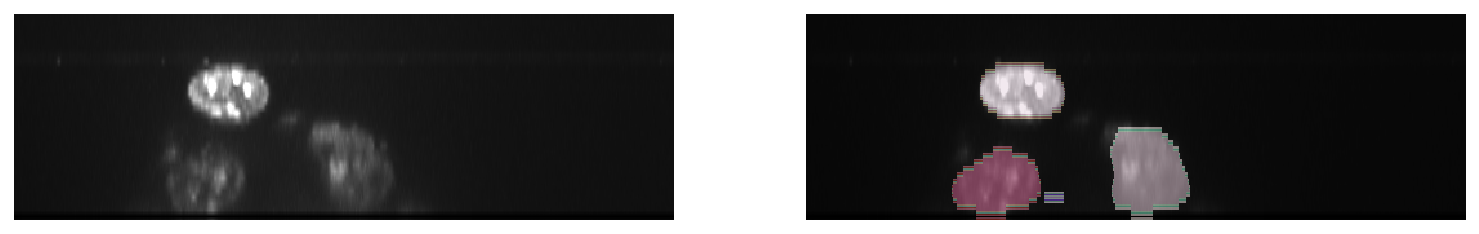

In [158]:
fig, ax = plt.subplots(1,2,figsize=(13,10))
ax[0].imshow(resize(np.amax(img_n[:,:,250:260],axis=2), output_shape=(160,512)), clim=(0,1), cmap='gray')
ax[0].axis('off')
ax[1].imshow(resize(np.amax(img_n[:,:,250:260],axis=2), output_shape=(160,512)), clim=(0,1), cmap='gray')
ax[1].imshow(resize(np.amax(labels[:,:,250:260],axis=2), output_shape=(160,512), anti_aliasing=False), cmap=lbl_cmap, alpha=0.5)
ax[1].axis('off')
plt.savefig(os.path.join(output_ex_dir, fname+'-projection-ZX.png'))

## Save predictions

Uncomment the lines in the following cell if you want to save the example image and the predicted label image to disk.

In [7]:
# save_tiff_imagej_compatible('example_image.tif', img, axes='ZYX')
# save_tiff_imagej_compatible('example_labels.tif', labels, axes='ZYX')

# Example results

In [8]:
def example(model, i, show_dist=True):
    img = normalize(X[i], 1,99.8, axis=axis_norm)
    labels, details = model.predict_instances(img)

    plt.figure(figsize=(13,8))
    z = img.shape[0] // 2
    y = img.shape[1] // 2
    img_show = img if img.ndim==3 else img[...,:3]    
    plt.subplot(221); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.subplot(222); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.subplot(223); plt.imshow(img_show[z],   cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XY slice')
    plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
    plt.subplot(224); plt.imshow(img_show[:,y], cmap='gray', clim=(0,1)); plt.axis('off'); plt.title('XZ slice')
    plt.imshow(labels[:,y], cmap=lbl_cmap, alpha=0.5)
    plt.tight_layout()
    plt.show()

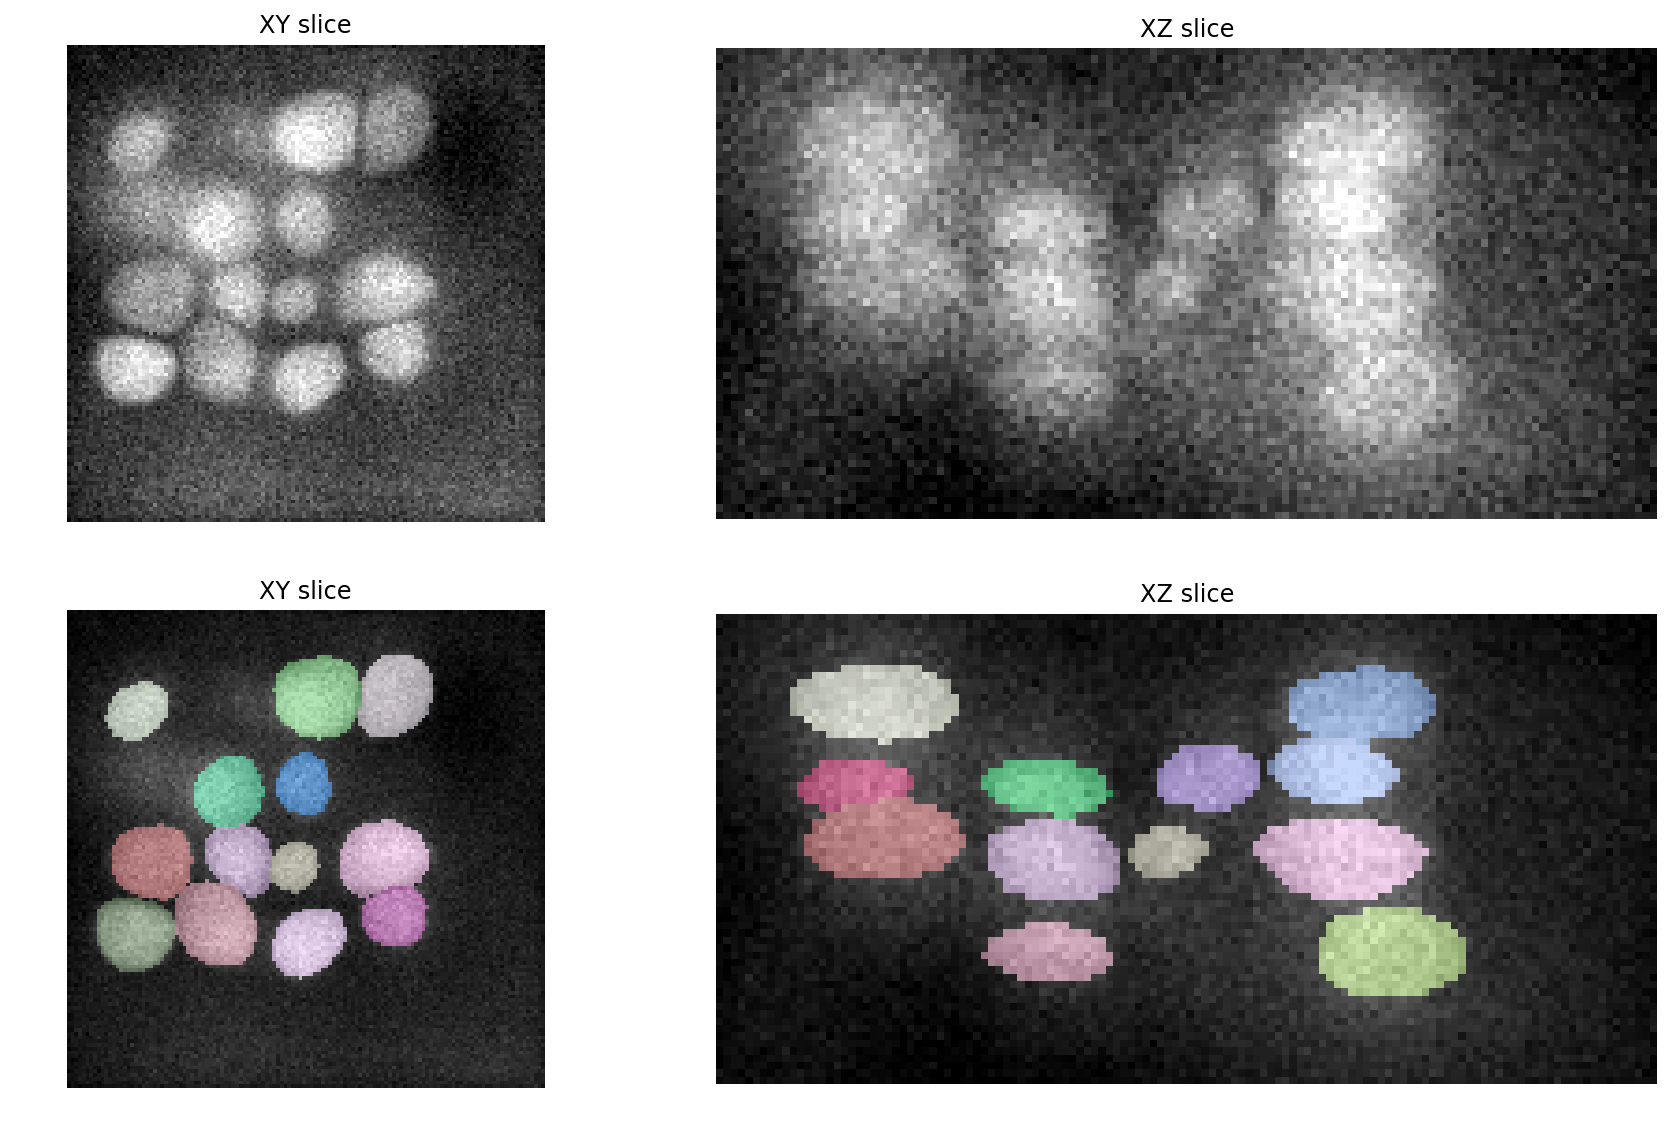

In [9]:
example(model, 0)

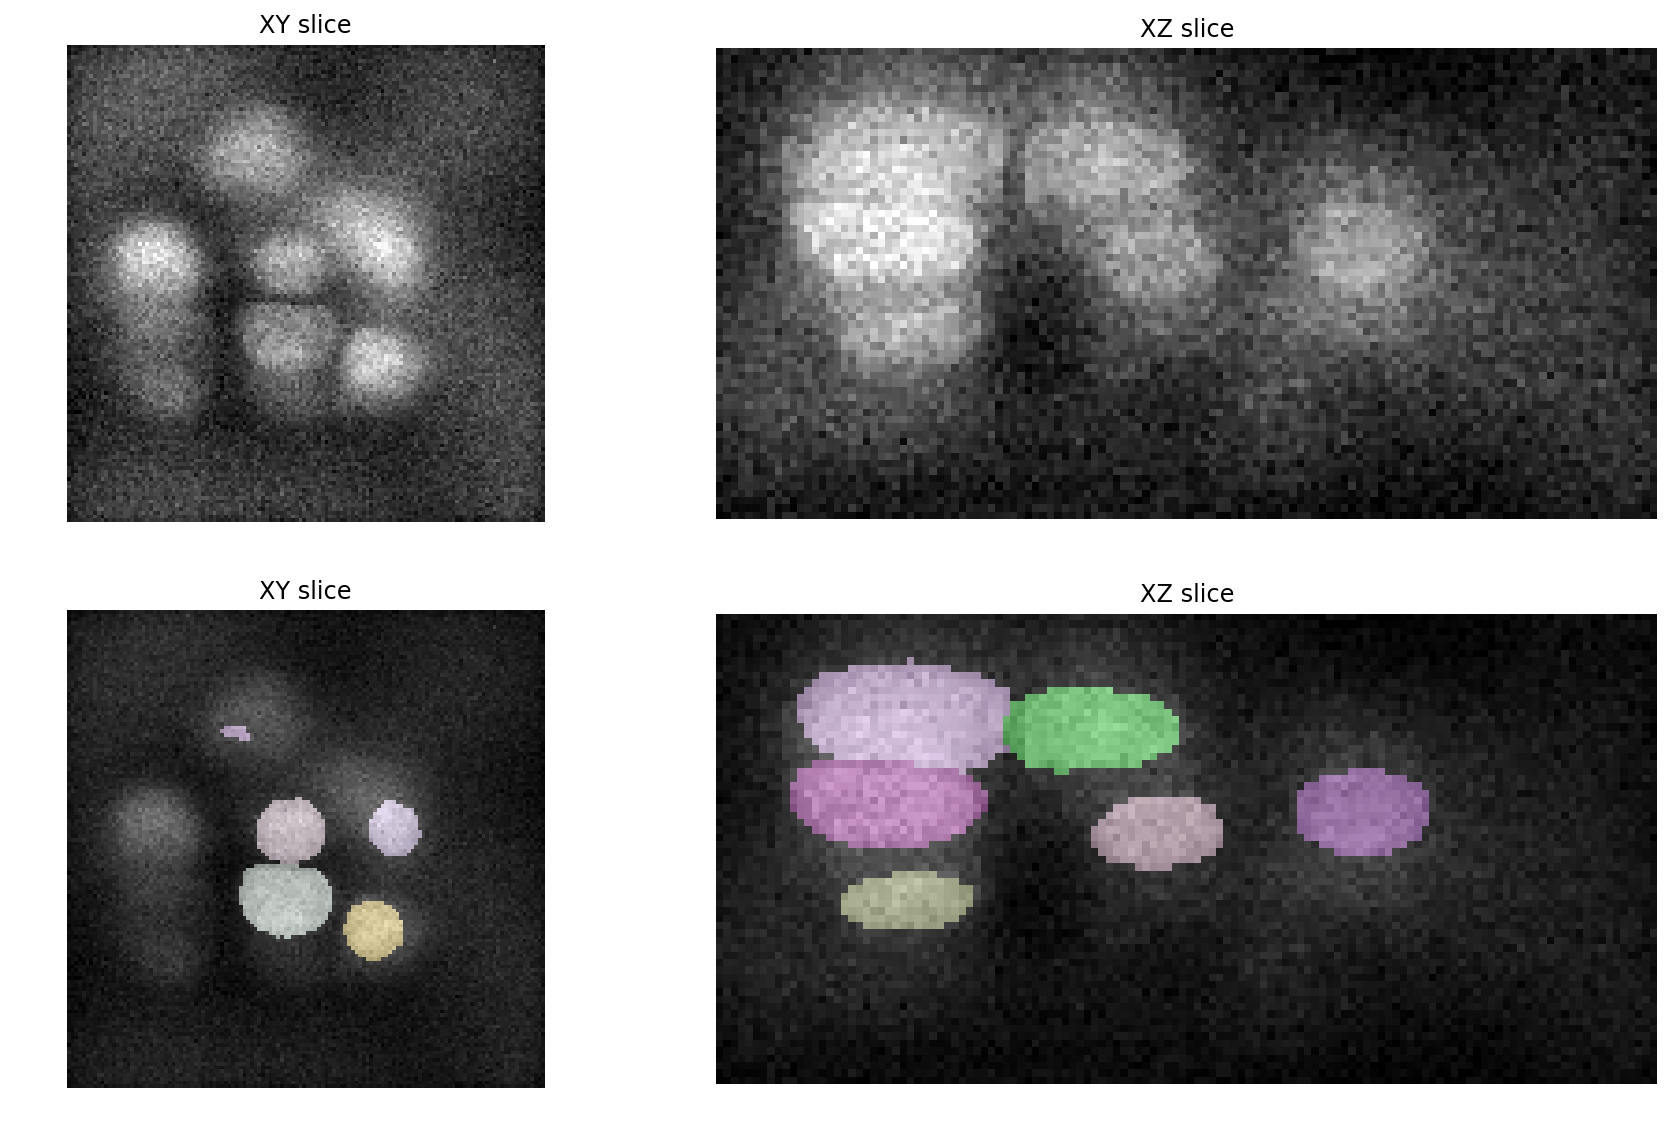

In [10]:
example(model, 1)

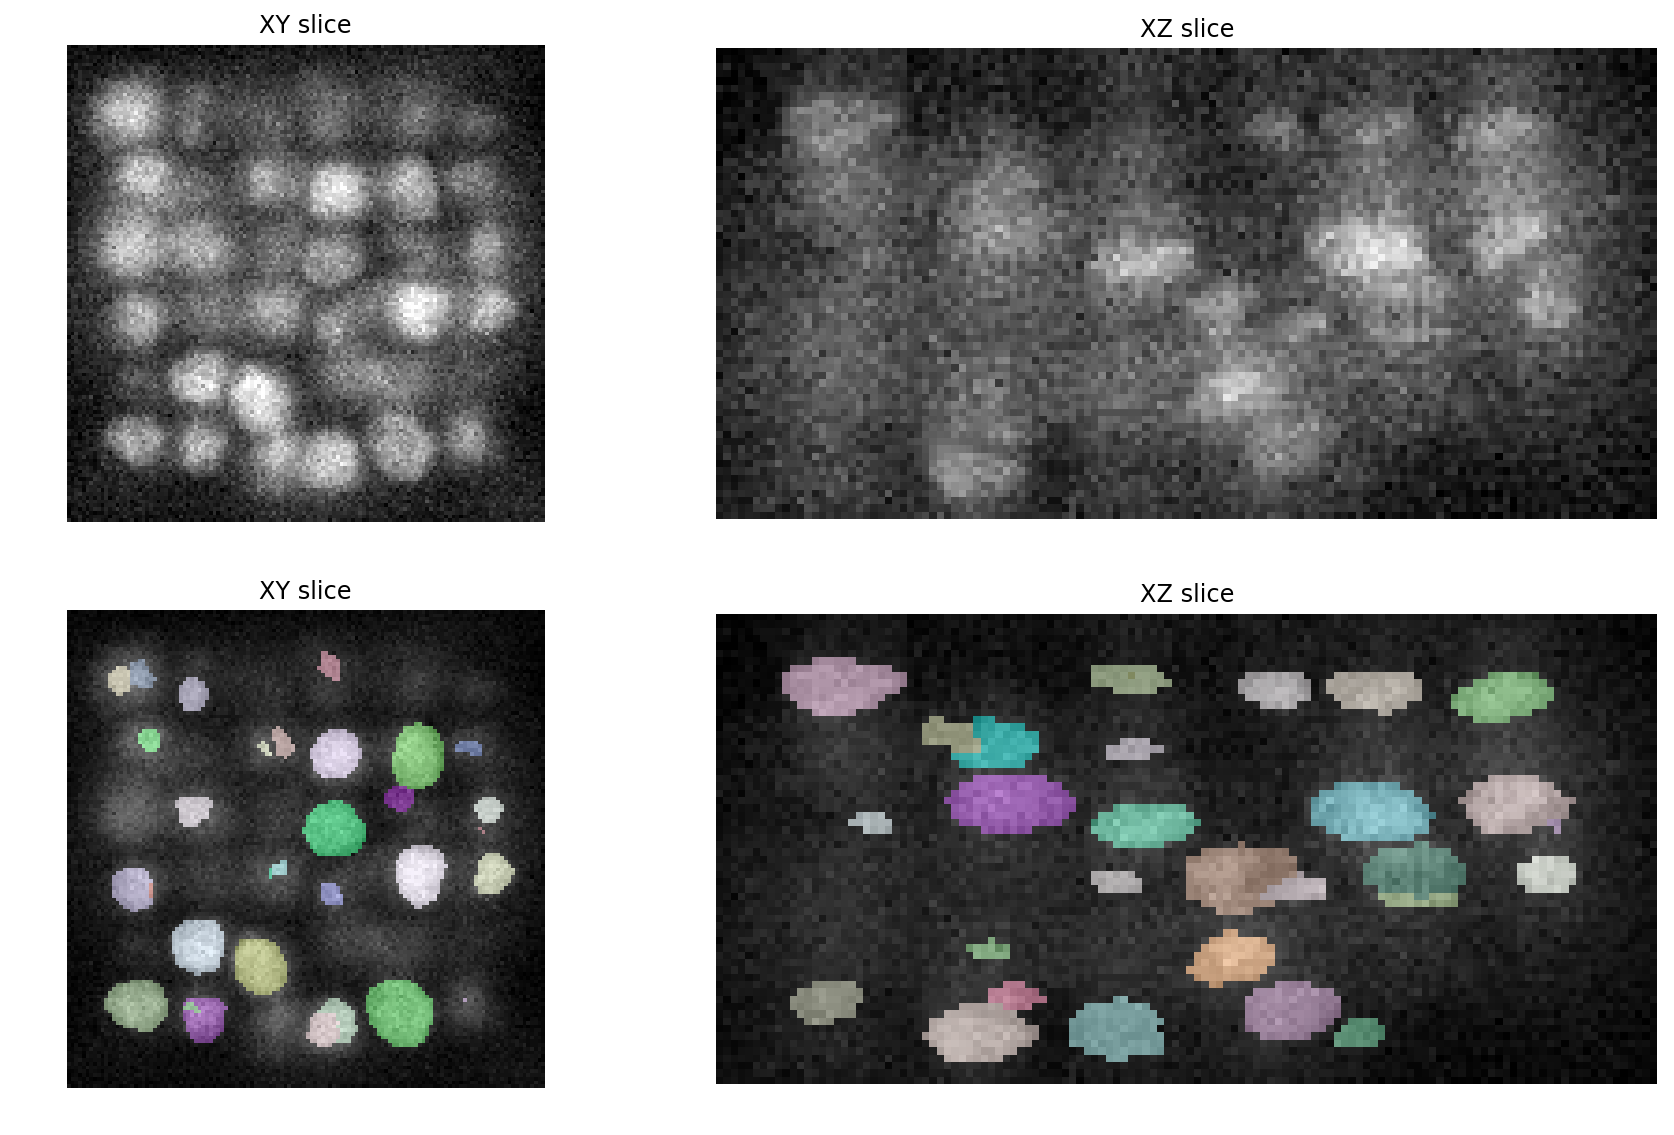

In [11]:
example(model, 2)